In [61]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]
from aicssegmentation.core.MO_threshold import MO

In [62]:
filename = "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/ctcf/raw-imgs/3500004636_100X_20210727_PM-alignV2-Scene-034-P34-G08.ome.tiff"
reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Attempted file (//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/ctcf/raw-imgs/3500004636_100X_20210727_PM-alignV2-Scene-034-P34-G08.ome.tiff) load with reader: aicsimageio.readers.bfio_reader.OmeTiledTiffReader failed with error: No module named 'bfio'
The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


(1, 4, 75, 600, 900)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


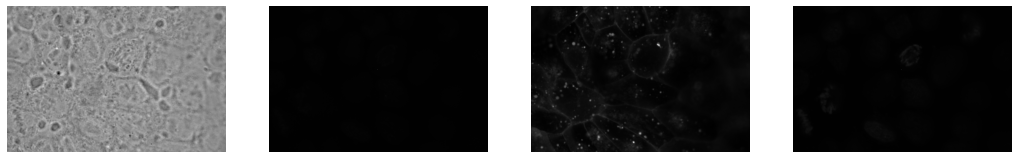

In [63]:
N_CHANNELS = IMG.shape[1] # N_CHANNELS = IMG.shape[1] 
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [64]:
#####################
structure_channel = 1

#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()

view(single_fluorescent_view(struct_img0))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [65]:
#################### PRE_PROCESSING ###################
    
# intenisty normalization (min/max)
intensity_scaling_param = [1, 14] # original: [1,14]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
    
# smoothing with boundary preserving smoothing
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

In [66]:
################### CORE ALGORITHM ###################

vesselness_sigma1 = [1] # original: 2 
vesselness_cutoff1 = 0.14 # original: 0.07 increase for thinner/less segmentation

response1 = vesselness3D(structure_img_smooth, sigmas=vesselness_sigma1,  tau=1, whiteonblack=True)
bw1 = response1 > vesselness_cutoff1
bw2 = structure_img_smooth>0.5

bw = np.logical_or(bw1, bw2)

In [67]:
################### POST-PROCESSING ###################

seg = remove_small_objects(bw>0, min_size=10, connectivity=1, in_place=False)

# output
seg = seg>0
seg = seg.astype(np.uint8)
seg[seg>0]=255

In [68]:
imsave("seg-ctcf-sc34-p34-g08.tiff", seg) 